Part 3: Expressive Power of Graph Neural Networks

In the following, we will look at 2 hard to distinguish graphs and try to understand what are the problems that GNNs are not able to solve and why this happends.

In [1]:
#@title [RUN] Import modules
import numpy as np
import seaborn as sns
import math
import itertools
import scipy as sp
import random

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch_geometric
from torch_geometric.datasets import Planetoid, ZINC, GNNBenchmarkDataset
from torch_scatter import scatter_mean, scatter_max, scatter_sum
from torch_geometric.utils import to_dense_adj
from torch.nn import Embedding

import pdb

#for nice visualisations
import networkx as nx
import matplotlib.pyplot as plt

from mycolorpy import colorlist as mcp
import matplotlib.cm as cm

from typing import Mapping, Tuple, Sequence, List
import colorama

import scipy.linalg
from scipy.linalg import block_diag

In [2]:
####### VISUALISATIONS #######

def draw_one_graph(ax, edges, label=None, node_emb=None, layout=None, special_color=False):
    """draw a graph with networkx based on adjacency matrix (edges)
    graph labels could be displayed as a title for each graph
    node_emb could be displayed in colors
    """
    graph = nx.Graph()
    edges = zip(edges[0], edges[1])
    graph.add_edges_from(edges)
    node_pos = layout(graph)
    #add colors according to node embeding
    if (node_emb is not None) or special_color:
        color_map = []
        node_list = [node[0] for node in graph.nodes(data = True)]
        for i,node in enumerate(node_list):
            #just ignore this branch
            if special_color:
                if len(node_list) == 3:
                    crt_color = (1,0,0)
                elif len(node_list) == 5:
                    crt_color = (0,1,0)
                elif len(node_list) == 4:
                    crt_color = (1,1,0)
                else:
                    special_list = [(1,0,0)] * 3 + [(0,1,0)] * 5 + [(1,1,0)] * 4
                    crt_color = special_list[i]
            else:
                crt_node_emb = node_emb[node]
                #map float number (node embeding) to a color
                crt_color = cm.gist_rainbow(crt_node_emb, bytes=True)
                crt_color = (crt_color[0]/255.0, crt_color[1]/255.0, crt_color[2]/255.0, crt_color[3]/255.0)
            color_map.append(crt_color)

        nx.draw_networkx_nodes(graph,node_pos, node_color=color_map,
                               nodelist = node_list, ax=ax)
        nx.draw_networkx_edges(graph, node_pos, ax=ax)
        nx.draw_networkx_labels(graph,node_pos, ax=ax)
    else:
        nx.draw_networkx(graph, node_pos, ax=ax)

def gallery(graphs, labels=None, node_emb=None, special_color=False, max_graphs=4, max_fig_size=(40, 10), layout=nx.layout.kamada_kawai_layout):
    ''' Draw multiple graphs as a gallery
    Args:
      graphs: torch_geometrics.dataset object/ List of Graph objects
      labels: num_graphs
      node_emb: num_graphs* [num_nodes x num_ch]
      max_graphs: maximum graphs display
    '''
    num_graphs = min(len(graphs), max_graphs)
    ff, axes = plt.subplots(1, num_graphs,
                            figsize=max_fig_size,
                            subplot_kw={'xticks': [], 'yticks': []})
    if num_graphs == 1:
        axes = [axes]
    if node_emb is None:
        node_emb = num_graphs*[None]
    if labels is None:
        labels = num_graphs * [" "]


    for i in range(num_graphs):
        draw_one_graph(axes[i], graphs[i].edge_index.numpy(), labels[i], node_emb[i], layout, special_color)
        if labels[i] != " ":
            axes[i].set_title(f"Target: {labels[i]}", fontsize=28)
        axes[i].set_axis_off()
    plt.show()

def hash_node_embedings(node_emb):
    """
    This function is a basic, non-bijective one for visualising the embedings.
    Please use it for guidance, not as a mathematical proof in Part 3.
    It is used just for educational/visualisation purpose.
    You are free to change it with whatever suits you best.
    Hash the tensor representing nodes' features
    to a number in [0,1] used to represent a color

    Args:
      node_emb: list of num_graphs arrays, each of dim (num_nodes x num_feats)
    Returns:
      list of num_graphs arrays in [0,1], each of dim (num_nodes)
    """
    chunk_size_graph = [x.shape[0] for x in node_emb]
    start_idx_graph = [0] + list(itertools.accumulate(chunk_size_graph))[:-1]

    node_emb_flatten = np.concatenate(node_emb).mean(-1)

    min_emb = node_emb_flatten.min()
    max_emb = node_emb_flatten.max()
    node_emb_flatten = (node_emb_flatten-min_emb)/(max_emb-min_emb++0.00001)

    #split in graphs again according to (start_idx_graph, chunk_size_graph)
    node_emb_hashed = [node_emb_flatten[i:i+l] for (i,l) in zip(start_idx_graph, chunk_size_graph)]
    return node_emb_hashed

####### PLOTS #######

def update_stats(training_stats, epoch_stats):
    """ Store metrics along the training
    Args:
      epoch_stats: dict containg metrics about one epoch
      training_stats: dict containing lists of metrics along training
    Returns:
      updated training_stats
    """
    if training_stats is None:
        training_stats = {}
        for key in epoch_stats.keys():
            training_stats[key] = []
    for key,val in epoch_stats.items():
        training_stats[key].append(val)
    return training_stats

def plot_stats(training_stats, figsize=(5, 5), name=""):
    """ Create one plot for each metric stored in training_stats
    """
    stats_names = [key[6:] for key in training_stats.keys() if key.startswith('train_')]
    f, ax = plt.subplots(len(stats_names), 1, figsize=figsize)
    if len(stats_names)==1:
        ax = np.array([ax])
    for key, axx in zip(stats_names, ax.reshape(-1,)):
        axx.plot(
            training_stats['epoch'],
            training_stats[f'train_{key}'],
            label=f"Training {key}")
        axx.plot(
            training_stats['epoch'],
            training_stats[f'val_{key}'],
            label=f"Validation {key}")
        axx.set_xlabel("Training epoch")
        axx.set_ylabel(key)
        axx.legend()
    plt.title(name)


def get_color_coded_str(i, color):
    return "\033[3{}m{}\033[0m".format(int(color), int(i))

def print_color_numpy(map, list_graphs):
    """ print matrix map in color according to list_graphs
    """
    list_blocks = []
    for i,graph in enumerate(list_graphs):
        block_i = (i+1)*np.ones((graph.num_nodes,graph.num_nodes))
        list_blocks += [block_i]
    block_color = block_diag(*list_blocks)

    map_modified = np.vectorize(get_color_coded_str)(map, block_color)
    print("\n".join([" ".join(["{}"]*map.shape[0])]*map.shape[1]).format(*[x for y in map_modified.tolist() for x in y]))



Part 3: Expressive Power of Graph Neural Networks

In the following, we will look at 2 hard to distinguish graphs and try to understand what are the problems that GNNs are not able to solve and why this happends.

In [3]:
class Graph(object):
    def __init__(self, edge_index, x, y):
        """ Graph structure
            for a mini-batch it will store a big (sparse) graph
            representing the entire batch
        Args:
            x: node features  [num_nodes x num_feats]
            y: graph labels   [num_graphs]
            edge_index: list of edges [2 x num_edges]
        """
        self.edge_index = edge_index
        self.x = x.to(torch.float32)
        self.y = y
        self.num_nodes = self.x.shape[0]
        #padding
        plen = (32 - (self.num_nodes%32))%32
        zeds = torch.Tensor([[0] for i in range(plen)])
        self.x = torch.concat( (self.x,zeds) )
        self.num_nodes = self.x.shape[0]

    #ignore this for now, it will be useful for batching
    def set_batch(self, batch):
        """ list of ints that maps each node to the graph it belongs to
            e.g. for batch = [0,0,0,1,1,1,1]: the first 3 nodes belong to graph_0 while
            the last 4 belong to graph_1
        """
        self.batch = batch

    # this function return a sparse tensor
    def get_adjacency_matrix(self):
        """ from the list of edges create
        a num_nodes x num_nodes sparse adjacency matrix
        """
        return torch.sparse.LongTensor(self.edge_index,
                                       # we work with a binary adj containing 1 if an edge exist
                                       torch.ones((self.edge_index.shape[1])),
                                       torch.Size((self.num_nodes, self.num_nodes))
                                       )

In [4]:
def create_mini_batch(graph_list: List[Graph]) -> Graph:
    """ Built a sparse graph from a batch of graphs
    Args:
        graph_list: list of Graph objects in a batch
    Returns:
        a big (sparse) Graph representing the entire batch
    """
    #insert first graph into the structure
    batch_edge_index = graph_list[0].edge_index
    batch_x = graph_list[0].x
    batch_y = graph_list[0].y
    batch_batch = torch.zeros((graph_list[0].num_nodes), dtype=torch.int64)
    node_offset = graph_list[0].num_nodes

    #append the rest of the graphs to the structure
    for idx, graph in enumerate(graph_list[1:]):

        # concat the features
        batch_x = torch.concat( [batch_x, graph.x] )
        # concat the labels
        batch_y = torch.concat( [batch_y, graph.y] )

        # concat the adjacency matrix as a block diagonal matrix
        batch_edge_index = torch.concat( [batch_edge_index,
                                          graph.edge_index + node_offset], dim=1 )
        # create the array of indexes mapping nodes in the batch-graph to the graph they belong to
        # specify the mapping between the new nodes and the graph they belong to (idx+1)
        batch_batch = torch.concat( [batch_batch,
                                     torch.tensor([ (idx+1) for xi in range(0,graph.num_nodes)]) ] )

        # update the node offset
        node_offset = node_offset + graph.num_nodes

        #create the big sparse graph
    batch_graph = Graph(batch_edge_index, batch_x, batch_y)
    #attach the index array to the Graph structure
    batch_graph.set_batch(batch_batch)
    return batch_graph

In [5]:
from torch.nn.modules.linear import Linear

class GINLayer(nn.Module):
    """A single GIN layer, implementing MLP(AX + (1+eps)X)"""
    def __init__(self, in_feats: int, out_feats: int, hidden_dim: int, eps: float=0.0):
        super(GINLayer, self).__init__()
        self.in_feats = in_feats
        self.out_feats = out_feats
        # ============ YOUR CODE HERE =============
        # epsilon should be a learnable parameter
        self.eps = torch.nn.Parameter(torch.Tensor([eps]), requires_grad=True)
        #self.eps = torch.nn.Parameter(torch.ones(1)), requires_grad=True)
        # =========================================
        self.linear1 = nn.Linear(self.in_feats, hidden_dim)
        self.linear2 = nn.Linear(hidden_dim, self.out_feats)
        self.activation = nn.ReLU()

    def forward(self, x, adj_sparse):
        # ============ YOUR CODE HERE =============
        # aggregate the neighbours as in GIN: (AX + (1+eps)X)
        x = adj_sparse @ x + (1+self.eps) * x
        # project the features (MLP_k)
        x = self.linear1(x)
        x = self.activation(x) # F.relu(x)
        out = self.linear2(x)

        # =========================================
        return out

class SimpleGIN(nn.Module):
    """
    A Graph Neural Network containing GIN layers
    as in https://arxiv.org/abs/1810.00826
    The readout function used to obtain graph-lvl representations
    is just the sum of the nodes in the graph

    Args:
        input_dim (int): Dimensionality of the input feature vectors
        output_dim (int): Dimensionality of the output softmax distribution
        num_layers (int): Number of layers
    """
    def __init__(self, input_dim, output_dim, hidden_dim,
                 num_layers=2, eps=0.0, molecular=True):
        super(SimpleGIN, self).__init__()
        self.num_layers = num_layers # please select num_layers>=2
        self.molecular = molecular
        # nodes in ZINC dataset are characterised by one integer (atom category)
        # we will create embeddings from the categorical features using nn.Embedding
        if self.molecular:
            self.embed_x = Embedding(28, hidden_dim)
        else:
            self.embed_x = Linear(input_dim, hidden_dim)

        # instead of nn.Linear as in SimpleMLP model,
        # now we have (num_layers) GINLayer(s), each with different parameters
        self.layers = [GINLayer(hidden_dim, hidden_dim, hidden_dim, eps) for _ in range(num_layers-1)]
        self.layers += [GINLayer(hidden_dim, output_dim, hidden_dim, eps)]
        self.layers = nn.ModuleList(self.layers)

    def forward(self, graph):
        adj_sparse = graph.get_adjacency_matrix()
        if self.molecular:
            x = self.embed_x(graph.x.long()).squeeze(1)
        else:
            x = self.embed_x(graph.x)

        for i in range(self.num_layers-1):
            x = self.layers[i](x, adj_sparse)
            x = F.relu(x)
        x = self.layers[-1](x, adj_sparse)

        # ============ YOUR CODE HERE =============
        # graph-level representations are obtain by pooling info from the nodes using sum
        #y_hat = scatter_sum(graph.x, graph.batch, dim=0)
        y_hat = scatter_sum(x, graph.batch, dim=0)
        # =========================================

        y_hat = y_hat.squeeze(-1)
        #return also the final node embeddings (for visualisations)
        return y_hat, x

In [45]:

class GIN(nn.Module):
    """
    A Graph Neural Network containing GIN layers
    as in https://arxiv.org/abs/1810.00826
    The readout function used to obtain graph-lvl representations
    aggregate pred from multiple layers (as in JK-Net)

    Args:
    input_dim (int): Dimensionality of the input feature vectors
    output_dim (int): Dimensionality of the output softmax distribution
    num_layers (int): Number of layers
    """
    def __init__(self,
                 input_dim,
                 output_dim,
                 hidden_dim,
                 num_layers=2,
                 eps=0.0,
                 molecular=True):
        super(GIN, self).__init__()
        self.num_layers = num_layers
        self.molecular = molecular
        # nodes in ZINC dataset are characterised by one integer (atom category)
        # we will create embeddings from the categorical features using nn.Embedding
        if self.molecular:
            self.embed_x = Embedding(10000, hidden_dim)
        else:
            self.embed_x = Linear(input_dim, hidden_dim)

        # ============ YOUR CODE HERE =============
        # parameter list for each layer
        self.params = [torch.nn.Parameter(torch.Tensor([eps]), requires_grad=True) for i in range(num_layers)]

        # should be the same as before (an nn.ModuleList of GINLayers)
        self.layers = [GINLayer(hidden_dim, hidden_dim, hidden_dim, eps) for _ in range(num_layers)] # all layers are this
        #self.layers += [GINLayer(hidden_dim, output_dim, hidden_dim, eps)]
        self.layers = nn.ModuleList(self.layers)

        # layer to compute prediction from the concatenated intermediate representations
        self.pred_layers = GINLayer(hidden_dim, output_dim, hidden_dim, eps)

        self.sigmoid = nn.Sigmoid()
        # =========================================

    def forward(self, graph):
        adj_sparse = graph.get_adjacency_matrix()
        if self.molecular:
            x = self.embed_x(graph.x.long()).squeeze(1)
        else:
            x = self.embed_x(graph.x)
        # ============ YOUR CODE HERE =============
        # perform the forward pass with the new readout function
        xs = []
        for i in range(self.num_layers):
            x = self.layers[i](x, adj_sparse)
            x = F.relu(x)
            #print('i: '+str(i))
            #print(x.shape)
            xs.append(self.params[i] * x)

        xconcat = torch.stack(xs, dim=1).sum(dim=1)
        #print('xconcat')
        #print(xconcat.shape)

        x2 = self.pred_layers(xconcat, adj_sparse) # get it to (xs[0].shape[0], 1)
        y_hat = scatter_sum(x2, graph.batch, dim=0)
        y_hat = self.sigmoid(y_hat.squeeze(-1))
        # =========================================
        # return also the final node embeddings (for visualisations)
        return y_hat, x

In [46]:
def train(dataset, model, optimiser, epoch, loss_fct, metric_fct, print_every):
    """ Train model for one epoch
    """
    model.train()
    num_iter = int(len(dataset)/BATCH_SIZE)
    for i in range(num_iter):
        batch_list = dataset[i*BATCH_SIZE:(i+1)*BATCH_SIZE]
        batch = create_mini_batch(batch_list)
        optimiser.zero_grad()
        y_hat, _ = model(batch)
        loss = loss_fct(y_hat.float(), batch.y.float())
        metric = metric_fct(y_hat.float(), batch.y.float())
        loss.backward()
        optimiser.step()
        if (i+1) % print_every == 0:
            print(f"Epoch {epoch} Iter {i}/{num_iter}",
                  f"Loss train {loss.data}; Metric train {metric.data}")
    return loss, metric

def evaluate(dataset, model, loss_fct, metrics_fct):
    """ Evaluate model on dataset
    """
    model.eval()
    # be careful in practice, as doing this way we will lose some
    # examples from the validation split, when len(dataset)%BATCH_SIZE != 0
    # think about how can you fix this!
    num_iter = int(len(dataset)/BATCH_SIZE)
    metrics_eval = 0.0
    loss_eval = 0.0
    for i in range(num_iter):
        batch_list = dataset[i*BATCH_SIZE:(i+1)*BATCH_SIZE]
        batch = create_mini_batch(batch_list)
        y_hat, _ = model(batch)
        #print(y_hat)
        metrics = metrics_fct(y_hat.float(), batch.y.float())
        loss = loss_fct(y_hat.float(), batch.y.float())
        metrics_eval += metrics.data
        loss_eval += loss.data
    metrics_eval /= num_iter
    loss_eval /= num_iter
    return loss_eval, metrics_eval

def train_eval(model, train_dataset, val_dataset, test_dataset,
               loss_fct, metric_fct, print_every=1):
    """ Train the model for NUM_EPOCHS epochs
    """
    #Instantiatie our optimiser
    optimiser = optim.Adam(model.parameters(), lr=LR)
    training_stats = None

    #initial evaluation (before training)
    val_loss, val_metric = evaluate(val_dataset, model, loss_fct, metric_fct)
    train_loss, train_metric = evaluate(train_dataset[:BATCH_SIZE], model,
                                        loss_fct, metric_fct)
    epoch_stats = {'train_loss': train_loss, 'val_loss': val_loss,
                   'train_metric': train_metric, 'val_metric': val_metric,
                   'epoch':0}
    training_stats = update_stats(training_stats, epoch_stats)

    for epoch in range(NUM_EPOCHS):
        if isinstance(train_dataset, list):
            random.shuffle(train_dataset)
        else:
            train_dataset.shuffle()
        train_loss, train_metric = train(train_dataset, model, optimiser, epoch,
                                         loss_fct, metric_fct, print_every)
        val_loss, val_metric = evaluate(val_dataset, model, loss_fct, metric_fct)
        print(f"[Epoch {epoch+1}]",
              f"train loss: {train_loss:.3f} val loss: {val_loss:.3f}",
              f"train metric: {train_metric:.3f} val metric: {val_metric:.3f}"
              )
        # store the loss and the computed metric for the final plot
        epoch_stats = {'train_loss': train_loss.detach().numpy(), 'val_loss': val_loss.detach().numpy(),
                       'train_metric': train_metric.detach().numpy(), 'val_metric': val_metric.detach().numpy(),
                       'epoch':epoch+1}
        training_stats = update_stats(training_stats, epoch_stats)

    test_loss, test_metric = evaluate(test_dataset, model,  loss_fct, metric_fct)
    print(f"Test metric: {test_metric:.3f}")
    return training_stats

In [47]:
#@title [RUN] Hard to distinguish graphs
def gen_hard_graphs_WL():

    x1 = torch.ones((10,1))
    edge_index1 = torch.tensor([[1, 1, 2, 2, 3, 3, 3, 4, 4, 5, 5, 6, 6, 6, 7, 7, 8, 8, 9, 9, 10, 10],
                                [2, 5, 1, 3, 2, 4, 6, 3, 5, 1, 4, 3, 7, 10, 6, 8, 7, 9, 8, 10, 6, 9]])-1
    y1 = torch.tensor([1])

    x2 = torch.ones((10,1))
    edge_index2 = torch.tensor([[1, 1, 2, 2, 2, 3, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7, 8, 8, 9, 9, 10, 10],
                                [2, 6, 1, 3, 7, 2, 4, 10, 3, 5, 4, 6, 1, 5, 2, 8, 7, 9, 8, 10, 3, 9]])-1
    y2 =  torch.tensor([2])

    graph1 = Graph(x=x1, edge_index=edge_index1, y=y1)
    graph2 = Graph(x=x2, edge_index=edge_index2, y=y2)
    return [graph1, graph2]

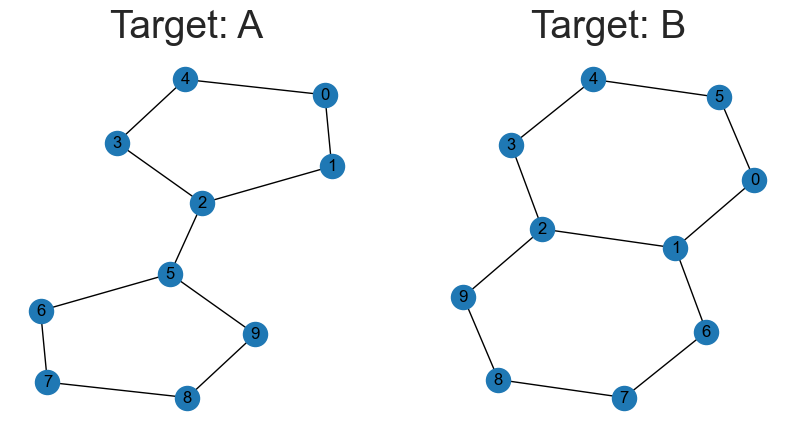

In [48]:
hard_graphs = gen_hard_graphs_WL()
gallery(hard_graphs, labels=["A","B"], max_fig_size=(10,5))

Note that, for efficiency, the adjacency matrix (self.get_adjacency_matrix()) is stored as a sparse matrix (using torch.sparse.LongTensor()). This means that, instead of the entire matrix, we will only store the indexes of the vertices and the value (weight) corresponding to each edge. This saves lots of memory in storing the tensors for which the majority of elements are zeros.
If you need to convert a sparse tensor x into a dense one you can use x.to_dense(). Moreover, many operations are directly supported for sparse tensors via torch.sparse (e.g. torch.sparse.mm() that multiplies a sparse matrix with a sparse/dense matrix).

Let's try to encode these graphs using our GIN Neural Network.

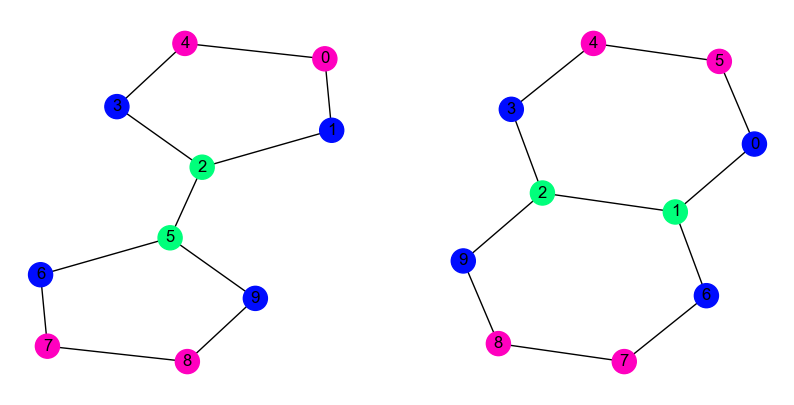

In [49]:
model_simple_gin = SimpleGIN(input_dim=30, output_dim=1, hidden_dim=64, num_layers=5, eps=0.1)

hard_batch = create_mini_batch(hard_graphs)
out, node_emb = model_simple_gin(hard_batch)

#split node_emb from batch into separate graphs
node_emb = node_emb.detach().numpy()
node_emb_split=[node_emb[:hard_graphs[0].num_nodes], node_emb[hard_graphs[0].num_nodes:]]

#encode node representation into an int in [0,1] denoting the color
node_emb_split = hash_node_embedings(node_emb_split)


gallery(hard_graphs, node_emb=node_emb_split, max_fig_size=(10,5))

In [50]:
hard_batch.x.shape

torch.Size([64, 1])

In the visualisation from above, the colors indicate the nodes embeddings, as predicted by the model. Remember from the course that, to obtain a graph-level representation, we pool the nodes embeddings using a *permutation invariant* function. This means that the multisets of colors determine the graph embedding. More exactly, if two graphs are encoded using the same multisets of colors, the final graph-representation will be the same.
This means that from the graph-level perspective the 2 graphs shown above are the same. However, for a human, it is obvious that this is not true.

**Why this is happening ❓**

Let's look at how the node embeddings are computed by a 5-layer GNN.

<!-- <center> -->
<img src="https://drive.google.com/uc?export=view&id=1Jt6zJVApmgS9VFbcKpzxOoBtrxos55iu" width="1000">
<!-- </center> -->

If we are looking into how the computational network looks like for the two graphs in 5 steps, we observe that they essentially looks very similar. The **important** difference that we are able to spot, while the GNNs are not, is that, after 5 layers of propagation, in one graph (left) we reach the same note from where we've started, while in the other graph (right) we reach a different one. Since from the structure persective the 2 nodes are the same, the GNN will encode them the same without realising the difference between them.

In the next section we will try to find how can we alleviate this and what could be the practical implications this problem raise.

As we have seen in the example above, GIN (and MPNNs in general) cannot distinguih any pair of non-isomorphic graphs. Based on this, we can devise a hierarchy of GNN models based on what pairs of graphs they can or cannot distinguish.

**Definition.** *We say that a GNN model B is strictly more powerful than another model A if B can distinguish all the pairs of attributed graphs that A can distinguish and there exists a pair of attributed graphs that B can distiguish but A cannot.*

In this section, we are going to build a GNN model that is more powerful than GIN and design a synthetic task on which this can be evaluated emprically. Then, you will also be asked to prove mathematically that your model is indeed more powerful.

Task 3.1: Construct a graph classification or regression task where a model with superior expressive power should do better than GIN. Split your dataset in a training, validation and testing subsets. (1 Mark)
Hint: Try to find more examples of pairs of graphs that GIN cannot distiguish and generalise them into a dataset.

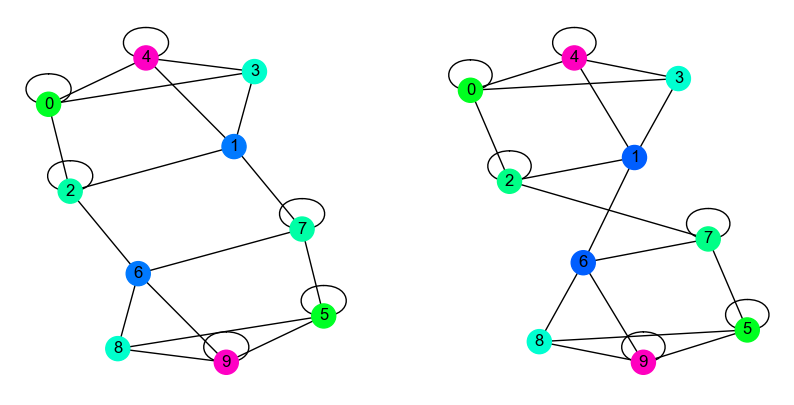

In [51]:
#@title [RUN] Hard to distinguish graphs

def gen_one(n,es):
    es_a = np.random.randint(0,n,es)
    es_b = np.random.randint(0,n,es)
    es_aL = np.concatenate( (es_a, es_b) )
    es_bL = np.concatenate( (es_b, es_a) )
    #edge_index1 = torch.tensor([es_a1L, es_b1L])
    edge_index = (es_aL, es_bL)
    return(edge_index)


def join_two(n,es):
    g1a,g1b = gen_one(n,es)
    #g2a,g2b = np.flip(g1a), np.flip(g1b) # gen_one(n,es)
    # update the node indices of graph 2
    g2a = g1a+n
    g2b = g1b+n
    # join the two graphs
    j1 = g1a[ 0:2 ]
    j2 = j1+n

    # build graph 2
    new_e1 = np.array([j1[0],j2[0],j1[1],j2[1]])
    new_e2 = np.array([j2[0],j1[0],j2[1],j1[1]])
    y1 = np.concatenate( (g1a, g2a, new_e1) )
    y2 = np.concatenate( (g1b, g2b, new_e2) )

    # build graph 1
    new_e1 = np.array([j1[0],j2[1],j1[1],j2[0]])
    new_e2 = np.array([j2[1],j1[0],j2[0],j1[1]])
    # build the edges
    #g2a,g2b = np.flip(g1a)+n, np.flip(g1b)+n
    x1 = np.concatenate( (g1a, g2a, new_e1) )
    x2 = np.concatenate( (g1b, g2b, new_e2) )
    #
    return( (
        torch.tensor([x1, x2], dtype=torch.long),
        torch.tensor([y1, y2], dtype=torch.long)
    ))


def gen_hard_graphs_DG(n,es):
    edge_index1, edge_index2 = join_two(n,es)
    x1 = torch.ones(len(set(edge_index1[0].tolist())),1)
    y1 = torch.tensor([0], dtype=torch.long)
    x2 = torch.ones(len(set(edge_index2[0].tolist())),1)
    y2 =  torch.tensor([1], dtype=torch.long)
    graph1 = Graph(x=x1, edge_index=edge_index1, y=y1)
    graph2 = Graph(x=x2, edge_index=edge_index2, y=y2)
    return [graph1, graph2]


def gen_hard_graphs_DG_aug(n,es):
    edge_index1, edge_index2 = join_two(n,es)
    n = len(set(edge_index1[0].tolist()))
    #x1 = torch.ones(len(set(edge_index1[0].tolist())),1)
    x1 = torch.randint(low=1111,high=9999,size=(n,1))
    y1 = torch.tensor([0], dtype=torch.long)
    #x2 = torch.ones(len(set(edge_index2[0].tolist())),1)
    x2 = torch.randint(low=1111,high=9999,size=(n,1))
    y2 =  torch.tensor([1], dtype=torch.long)
    graph1 = Graph(x=x1, edge_index=edge_index1, y=y1)
    graph2 = Graph(x=x2, edge_index=edge_index2, y=y2)
    return [graph1, graph2]


hard_graphs = gen_hard_graphs_DG(5,15)

model_simple_gin = SimpleGIN(input_dim=32, output_dim=1, hidden_dim=64, num_layers=4, eps=0.1)

hard_batch = create_mini_batch(hard_graphs)

out, node_emb = model_simple_gin(hard_batch)

#split node_emb from batch into separate graphs
node_emb = node_emb.detach().numpy()
node_emb_split = [node_emb[:hard_graphs[0].num_nodes], node_emb[hard_graphs[0].num_nodes:]]

#encode node representation into an int in [0,1] denoting the color
node_emb_split = hash_node_embedings(node_emb_split)

gallery(hard_graphs, node_emb=node_emb_split, max_fig_size=(10, 5))



In [52]:
# Construct dataset.
traindat = gen_hard_graphs_DG(5,10)
for i in range(1280):
    traindat += gen_hard_graphs_DG(5,10)

testdat = gen_hard_graphs_DG(5,10)
for i in range(640):
    testdat += gen_hard_graphs_DG(5,10)

valdat = gen_hard_graphs_DG(5,10)
for i in range(640):
    valdat += gen_hard_graphs_DG(5,10)


In [53]:
BATCH_SIZE = 64 #@param {type:"integer"}
NUM_EPOCHS =   30#@param {type:"integer"}
HIDDEN_DIM =   64#@param {type:"integer"}
LR         = 0.001 #@param {type:"number"}


[Epoch 1] train loss: 0.687 val loss: 0.696 train metric: 0.687 val metric: 0.696
[Epoch 2] train loss: 0.696 val loss: 0.710 train metric: 0.696 val metric: 0.710
[Epoch 3] train loss: 0.694 val loss: 0.695 train metric: 0.694 val metric: 0.695
[Epoch 4] train loss: 0.684 val loss: 0.700 train metric: 0.684 val metric: 0.700
[Epoch 5] train loss: 0.701 val loss: 0.698 train metric: 0.701 val metric: 0.698
[Epoch 6] train loss: 0.699 val loss: 0.694 train metric: 0.699 val metric: 0.694
[Epoch 7] train loss: 0.687 val loss: 0.715 train metric: 0.687 val metric: 0.715
[Epoch 8] train loss: 0.693 val loss: 0.694 train metric: 0.693 val metric: 0.694
[Epoch 9] train loss: 0.692 val loss: 0.693 train metric: 0.692 val metric: 0.693
[Epoch 10] train loss: 0.696 val loss: 0.695 train metric: 0.696 val metric: 0.695
[Epoch 11] train loss: 0.689 val loss: 0.699 train metric: 0.689 val metric: 0.699
[Epoch 12] train loss: 0.691 val loss: 0.693 train metric: 0.691 val metric: 0.693
[Epoch 13] tr

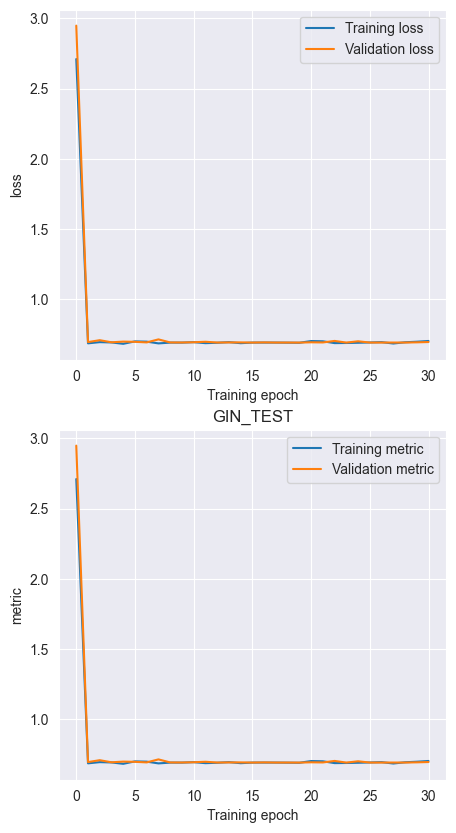

In [57]:
model_gin = GIN(input_dim=hard_batch.x.size()[-1], output_dim=1, hidden_dim=HIDDEN_DIM, num_layers=4, eps=0.1)

#Train GIN model:
train_stats_gin_zinc = train_eval(model_gin,
                                  traindat, valdat,testdat,
                                  loss_fct=F.binary_cross_entropy,
                                  metric_fct=F.binary_cross_entropy, print_every=150)

plot_stats(train_stats_gin_zinc, name='GIN_TEST', figsize=(5, 10))


Task 3.2: Think of a feature augmentation procedure that can increase the expressive power of GIN. Is GIN + Feature Augmentation better than GIN on the synthetic task? Explain your results. (1 Mark)
How can you augment the initial graph features with additional information about the graph that could lead to higher discriminativity when applying a GIN model on top?

In [55]:
# ============ YOUR CODE HERE =============
# Implement GIN with Feature Augmentation
# =========================================

# Construct dataset.
traindat2 = gen_hard_graphs_DG_aug(5,10)
for i in range(1280):
    traindat2 += gen_hard_graphs_DG_aug(5,10)

testdat2 = gen_hard_graphs_DG_aug(5,10)
for i in range(640):
    testdat2 += gen_hard_graphs_DG_aug(5,10)

valdat2 = gen_hard_graphs_DG_aug(5,10)
for i in range(640):
    valdat2 += gen_hard_graphs_DG_aug(5,10)


[Epoch 1] train loss: 0.707 val loss: 0.715 train metric: 0.707 val metric: 0.715
[Epoch 2] train loss: 0.688 val loss: 0.710 train metric: 0.688 val metric: 0.710
[Epoch 3] train loss: 0.648 val loss: 0.714 train metric: 0.648 val metric: 0.714
[Epoch 4] train loss: 0.654 val loss: 0.762 train metric: 0.654 val metric: 0.762
[Epoch 5] train loss: 0.461 val loss: 0.989 train metric: 0.461 val metric: 0.989
[Epoch 6] train loss: 0.455 val loss: 1.236 train metric: 0.455 val metric: 1.236
[Epoch 7] train loss: 0.199 val loss: 1.472 train metric: 0.199 val metric: 1.472
[Epoch 8] train loss: 0.117 val loss: 2.292 train metric: 0.117 val metric: 2.292
[Epoch 9] train loss: 0.278 val loss: 2.118 train metric: 0.278 val metric: 2.118
[Epoch 10] train loss: 0.156 val loss: 2.780 train metric: 0.156 val metric: 2.780
[Epoch 11] train loss: 0.077 val loss: 3.474 train metric: 0.077 val metric: 3.474
[Epoch 12] train loss: 0.140 val loss: 4.499 train metric: 0.140 val metric: 4.499
[Epoch 13] tr

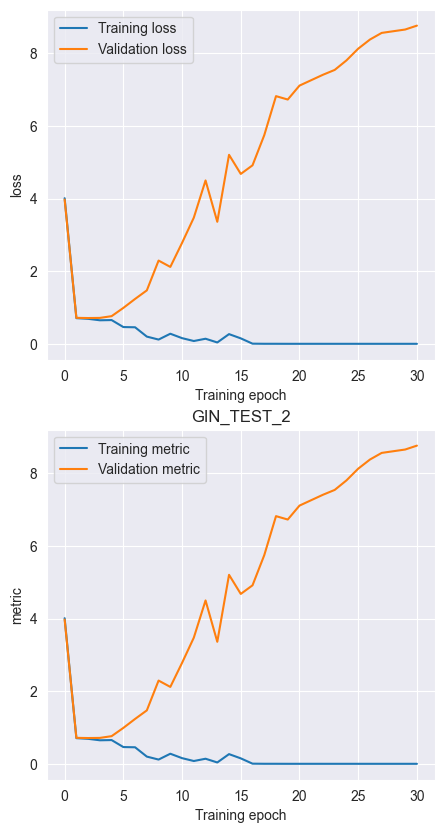

In [56]:
# ============ YOUR CODE HERE =============
# Evaluate your model on this new dataset against GIN.
# =========================================

model_gin = GIN(input_dim=traindat2[0].x.size()[0], output_dim=1, hidden_dim=HIDDEN_DIM, num_layers=4, eps=0.1)

#Train GIN model:
train_stats_gin_zinc = train_eval(model_gin,
                                  traindat2, valdat2, testdat2,
                                  loss_fct=F.binary_cross_entropy,
                                  metric_fct=F.binary_cross_entropy, print_every=150)

plot_stats(train_stats_gin_zinc, name='GIN_TEST_2', figsize=(5, 10))
